<a href="https://colab.research.google.com/github/Eitams/NLP_Exercise/blob/main/NLP_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text analysis - Bacteria VS Bactriophage

In [1]:
#Upgrade profiling library and "Restart runtime"
#!pip install --upgrade pandas-profiling
#!pip install langdetect
#!pip install spacy
#!pip install --upgrade spacy
#!pip install scattertext
#! spacy download en_core_web_lg


In [2]:
## Set working directory
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/NLP')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
## Import packeges
## For Data processing
import pandas as pd
import numpy as np
import collections
pd.options.display.max_colwidth = 100
pd.options.display.max_columns = 30

import pandas_profiling as prof
from pathlib import Path

## For plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 6.0)
import plotly.graph_objs as go

import plotly.graph_objs as go
from plotly.offline import iplot
from IPython.core.interactiveshell import InteractiveShell

## Text processing
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

## for Named-entity recognition (NER)
import spacy

## for sentiment
from textblob import TextBlob

## for language detection
import langdetect

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
## Loading data
df_bacteria = pd.read_csv("bacteria_df.csv", index_col=0)
df_phage = pd.read_csv("bacteriophage_df.csv", index_col=0)

In [5]:
# Dropping first row of df_phage (Its the general discription and not phage type)
df_phage.drop(index = 0, inplace = True)
df_phage.head()

,Name,Description
1,Bacillus virus AP50,Bacillus virus AP50 is a species of bacteriophage that infects Bacillus anthracis bacteria. Orig...
2,Bacteriophage AP205,Bacteriophage AP205 is a bacteriophage that infects Acinetobacter bacteria. Contains a genome li...
3,Bacteriophage f2,"Bacteriophage f2 is an icosahedral, positive-sense single-stranded RNA virus that infects the ba..."
4,Bacteriophage MS2,"Bacteriophage MS2 (Emesvirus zinderi), commonly called MS2, is an icosahedral, positive-sense si..."
5,Bacteriophage Mu,"Bacteriophage Mu, also known as mu phage or mu bacteriophage, is a muvirus (the first of its kin..."


In [6]:
##-----------------------------
## Merge data into 1 data frame
##-----------------------------
## Add type column
df_bacteria["Type"] = "Bacteria" 
df_phage["Type"] = "Bacteriophage" 

## Merge df
df = pd.concat([df_bacteria, df_phage])

In [7]:
df.head()

,Name,Description,Type
0,Acinetobacter baumannii,"Acinetobacter baumannii is a typically short, almost round, rod-shaped (coccobacillus) Gram-nega...",Bacteria
1,Actinomyces israelii,"Actinomyces israelii is a species of Gram-positive, rod-shaped bacteria within the genus Actinom...",Bacteria
2,Agrobacterium tumefaciens,Agrobacterium radiobacter (more commonly known as Agrobacterium tumefaciens) is the causal agent...,Bacteria
3,Anaplasma,"Anaplasma is a genus of bacteria of the alphaproteobacterial order Rickettsiales, family Anaplas...",Bacteria
4,Anaplasma phagocytophilum,Anaplasma phagocytophilum (formerly Ehrlichia phagocytophilum) is a Gram-negative bacterium that...,Bacteria


In [8]:
#profile = prof.ProfileReport(df, title="Profile Report wikipedia pages", explorative=True)
#profile.to_file(Path("First_profile_report_wikipedia.html"))

Key insights:  
No missing data is in any of the columns.  
The Type group is unbalanced we will ploted again in the following step.
No data is repeting itself.

## Exploratory data analysis

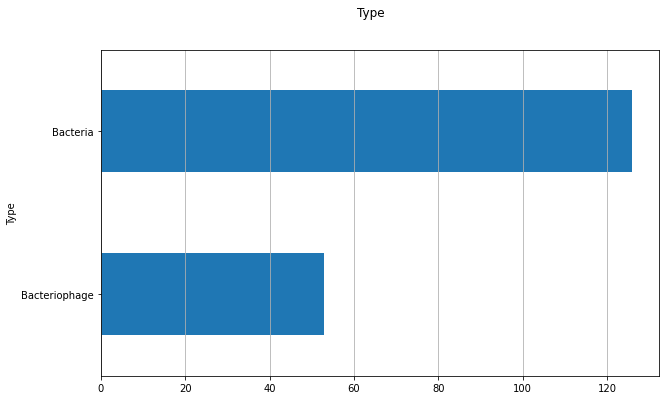

In [9]:
## Exploring the distribution of data types
x = "Type" 
fig, ax = plt.subplots()
fig.suptitle(x, fontsize=12)
df[x].reset_index().groupby(x).count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

Key insights:  
The data is unbalanced, in future work we may decide to resample it.

In [10]:
## Detecting the language the text is writting in
df['lang'] = df["Description"].apply(lambda x: langdetect.detect(x) if 
                                 x.strip() != "" else "")
print(df["lang"].unique()) ## Print unique values in language column

['en']


Key insights:  
As expected  all pages detected as written in english (we only downloaded pages from the english wikipedia).

## Text Preprocessing

In [11]:
'''
Function which remove html tags from text string.
'''
def utils_basic_clean(text):
    ## clean ( Remove HTML tags)
    text = str(text).replace("(<br/>)", "") ## line break element
    text = text.replace('(<a).*(>).*(</a>)', '') ## Hyperlink tag
    text = text.replace('(&amp)', '')
    text = text.replace('(&gt)', '')
    text = text.replace('(&lt)', '')
    text = text.replace('(\xa0)', ' ') 
    
    return(text)



'''
Function which preprocess a text string.
:parameter
    :param text: string - name of column containing text
    :param lst_stopwords: list - list of stopwords to remove
    :param flg_stemm: bool - whether stemming is to be applied
    :param flg_lemm: bool - whether lemmitisation is to be applied
:return
    cleaned text
'''
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then remove leading and trailing whitespaces)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [12]:
## Creating a list of stopwords (usnig NLTK packege) to remove from text
lst_stopwords = nltk.corpus.stopwords.words("english")
print(lst_stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [13]:
## Apply basic cleaning on Description column
df["Description"] = df["Description"].apply(lambda x: utils_basic_clean(x))

## Apply cleaning and preprocessing on Description column using utils function with lemmatization of words -saving as a new column-
df["Description_clean"] = df["Description"].apply(lambda x: 
    utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords=lst_stopwords))

In [14]:
df.head()

,Name,Description,Type,lang,Description_clean
0,Acinetobacter baumannii,"Acinetobacter baumannii is a typically short, almost round, rod-shaped (coccobacillus) Gram-nega...",Bacteria,en,acinetobacter baumannii typically short almost round rodshaped coccobacillus gramnegative bacter...
1,Actinomyces israelii,"Actinomyces israelii is a species of Gram-positive, rod-shaped bacteria within the genus Actinom...",Bacteria,en,actinomyces israelii specie grampositive rodshaped bacteria within genus actinomyces known live ...
2,Agrobacterium tumefaciens,Agrobacterium radiobacter (more commonly known as Agrobacterium tumefaciens) is the causal agent...,Bacteria,en,agrobacterium radiobacter commonly known agrobacterium tumefaciens causal agent crown gall disea...
3,Anaplasma,"Anaplasma is a genus of bacteria of the alphaproteobacterial order Rickettsiales, family Anaplas...",Bacteria,en,anaplasma genus bacteria alphaproteobacterial order rickettsiales family anaplasmataceae anaplas...
4,Anaplasma phagocytophilum,Anaplasma phagocytophilum (formerly Ehrlichia phagocytophilum) is a Gram-negative bacterium that...,Bacteria,en,anaplasma phagocytophilum formerly ehrlichia phagocytophilum gramnegative bacterium unusual trop...


## Feature engineering

### Length analysis

In [15]:
## Calculating new features from raw data column (Description)
## Word count
df['word_count'] = df["Description"].apply(lambda x: len(str(x).split(" ")))
## Character count
df['char_count'] = df["Description"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))
## sentence count
df['sentence_count'] = df["Description"].apply(lambda x: len(str(x).split(".")))
## average word length
df['avg_word_length'] = df['char_count'] / df['word_count']
## average sentence length
df['avg_sentence_length'] = df['word_count'] / df['sentence_count']

df.head(2)

,Name,Description,Type,lang,Description_clean,word_count,char_count,sentence_count,avg_word_length,avg_sentence_length
0,Acinetobacter baumannii,"Acinetobacter baumannii is a typically short, almost round, rod-shaped (coccobacillus) Gram-nega...",Bacteria,en,acinetobacter baumannii typically short almost round rodshaped coccobacillus gramnegative bacter...,354,2118,27,5.983051,13.111111
1,Actinomyces israelii,"Actinomyces israelii is a species of Gram-positive, rod-shaped bacteria within the genus Actinom...",Bacteria,en,actinomyces israelii specie grampositive rodshaped bacteria within genus actinomyces known live ...,72,383,6,5.319444,12.000000


In [16]:
'''
Function which plot the histogram and distplot of group types
'''
def hist_compare(colum):
  x, y = colum, "Type"
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize= (12,5))
  fig.suptitle(x, fontsize=12)
  colors = ['#1f78b4', '#b2df8a']

  for c, i in zip(colors, df[y].unique()):
      sns.histplot(df[df[y]==i][x], bins=10, color=c, ax=ax[0])
      sns.kdeplot(df[df[y]==i][x], ax=ax[1], color=c)

  ax[0].grid(True)
  ax[0].legend(df[y].unique())
  ax[1].grid(True)
  plt.show()

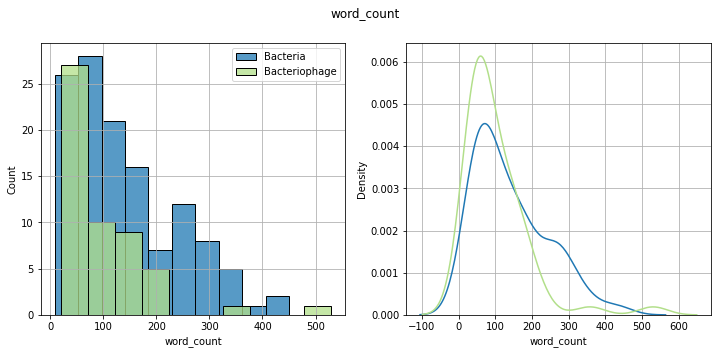

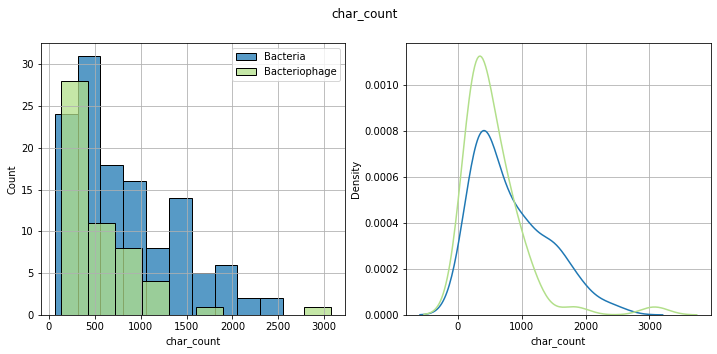

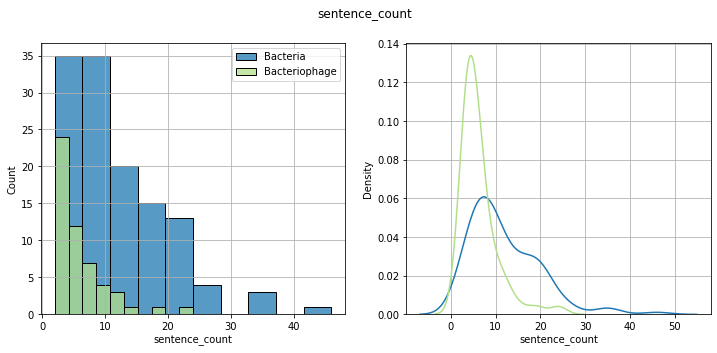

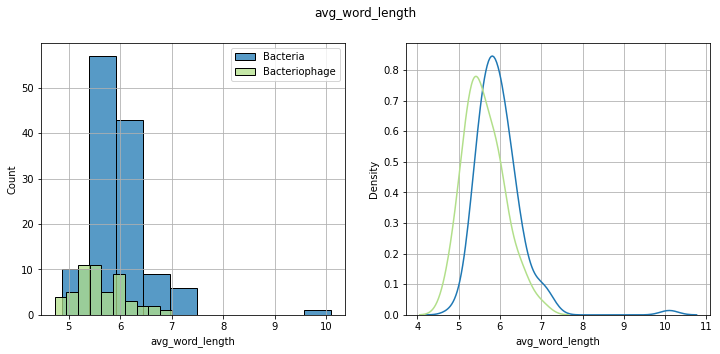

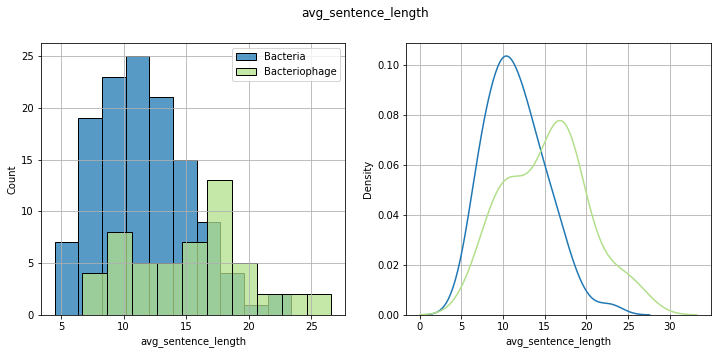

In [17]:
## Plot length features
hist_compare("word_count")
hist_compare("char_count")
hist_compare("sentence_count")
hist_compare("avg_word_length")
hist_compare("avg_sentence_length")

Key insights:  
The density plot distribution is more representable in our case due to the unbalnced data.  
A differance in groups density distribution is notecible at the word count, char count and sentance count, where the probability for the value to be bigger then ~200 , ~1000 and ~10  respectively is higher for the bacteria group as an example.
An opposite realation is visabule for the avg sentance length


## Polarity analysis

In [18]:
# Add polarity columns
df['Polarity'] = df['Description'].map(lambda text: TextBlob(str(text)).sentiment.polarity)

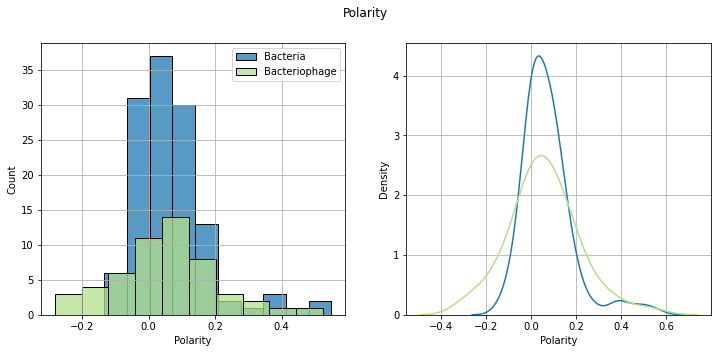

In [19]:
## Plot polatiry
hist_compare("Polarity")

Key insights:  
As expected very similar normal distribution for both groups around the 0 with a bit of a widder bell for the bacteriophage group.

## Word count

In [20]:
# Let's start with some visuals
!pip install WordCloud

In [21]:
from wordcloud import WordCloud 
import matplotlib.pyplot as plt 
import seaborn as sns

# Set preferences
sns.set(color_codes=True)

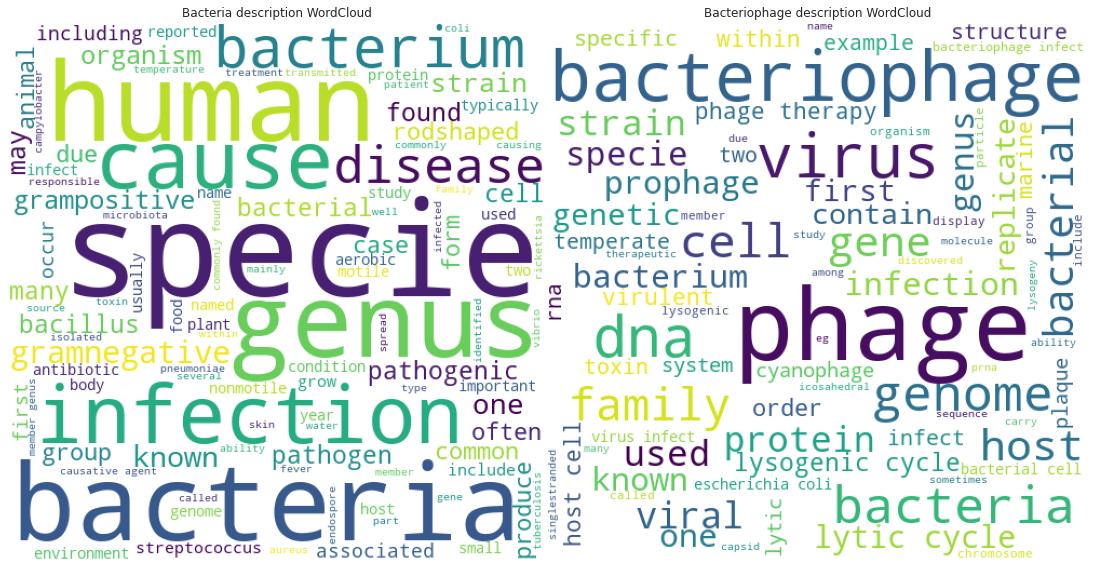

In [22]:
## For the word count we will use the clean text (No stopwords and with lemmitisation of the words)
## Get all description texts
all_desc_bacteria = df.loc[df["Type"]=="Bacteria","Description_clean"]
all_desc_phage = df.loc[df["Type"]=="Bacteriophage","Description_clean"]
# Now let's generate a wordcloud for some reviews
wordcloud_bacteria = WordCloud(width = 500, height = 500, 
                background_color ='white',
                min_font_size = 10).generate(all_desc_bacteria.str.cat())

wordcloud_phage = WordCloud(width = 500, height = 500, 
                background_color ='white',
                min_font_size = 10).generate(all_desc_phage.str.cat())
  
# plot the WordCloud image
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,15))                        
#plt.figure(figsize = (6, 6), facecolor = None) 
ax1.imshow(wordcloud_bacteria) 
ax1.axis("off") 
ax1.set_title("Bacteria description WordCloud")
ax2.imshow(wordcloud_phage) 
ax2.axis("off") 
ax2.set_title("Bacteriophage description WordCloud")

plt.tight_layout(pad = 0) 
plt.show()

Key insights:   
The words Human and animal which are the direct host of the bacteria are visuable at the bacteria cloud and not at the bactriophage cloud.
The word Bacteria (not like bacteriophage) is presented in both clouds -the name of one group and the direct host of the other. 


In [23]:
from IPython.display import IFrame
from IPython.core.display import display, HTML
import scattertext as st
from scattertext import CorpusFromPandas, produce_scattertext_explorer
import spacy
#display(HTML("<style>.container { width:98% !important; }</style>"))

In [24]:
# We will be using the large English spacy model (pipeline)
nlp = spacy.load("en_core_web_lg")

In [25]:
# Prepare parsed data for scattertext analysis
# Tokenize the data with spacy
df['parsed'] = df['Description_clean'].apply(nlp)

In [26]:
# Convert dataframe into Scattertext corpus
corpus = st.CorpusFromParsedDocuments(df, category_col='Type', parsed_col='parsed').build()

In [27]:
# Visuals without stop words
html = st.produce_scattertext_explorer(corpus, category='Bacteria', 
                                       category_name='Bacteria', 
                                       not_category_name='Bacteriophage', 
                                       minimum_term_frequency=5, 
                                       term_significance = st.LogOddsRatioUninformativeDirichletPrior())

In [28]:
file_name = 'no_stops.html'
open(file_name, 'wb').write(html.encode('utf-8'))

676931

In [29]:
import IPython
IPython.display.HTML(filename='no_stops.html')

Key insights:  
The buttom right corner and the upper left corner show us the tokens that are the most distinct and frequant for each category- among them we can see for Bacteria: pathogen, roadshape, agar, gramposative  
Bacteriophage: phage, bacteriophage, virus, viral

N-gramming

In [30]:
'''
Function which return the requancy of the selected gram number for the text
'''
def get_top_n_words(corpus, n=None, x=1, y=1):
    vec = CountVectorizer(ngram_range=(x, y)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words_bacteria = get_top_n_words(all_desc_bacteria, 20)
common_words_phage = get_top_n_words(all_desc_phage, 20)

unigrams_bacteria = pd.DataFrame(common_words_bacteria, columns = ['word' , 'count'])
unigrams_bacteriophage = pd.DataFrame(common_words_phage, columns = ['word' , 'count'])


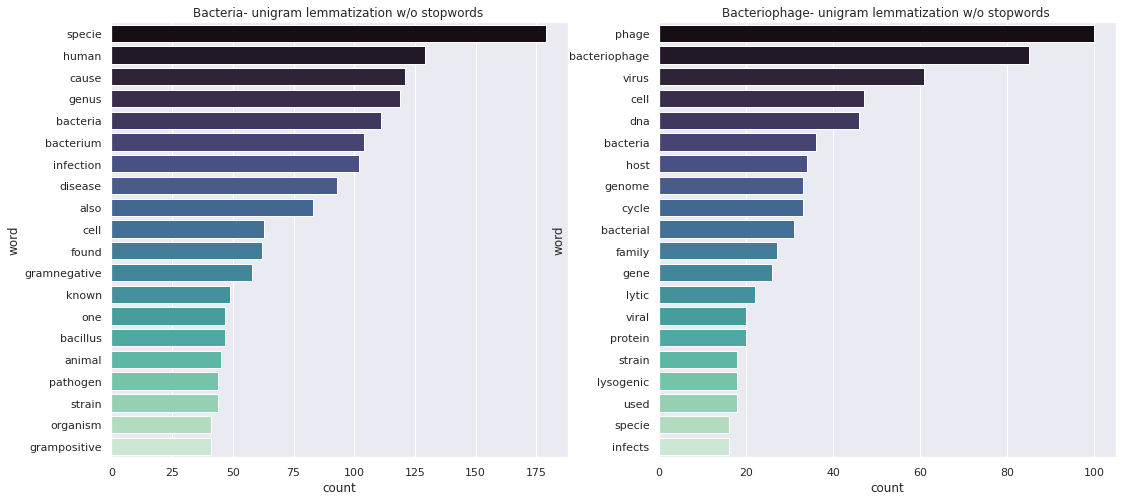

In [31]:
'''
Plotting Unigram of bacteria vs bacteriophage
'''
## Calculating unigram
common_words_bacteria = get_top_n_words(all_desc_bacteria, 20)
common_words_phage = get_top_n_words(all_desc_phage, 20)
unigrams_bacteria = pd.DataFrame(common_words_bacteria, columns = ['word' , 'count'])
unigrams_bacteriophage = pd.DataFrame(common_words_phage, columns = ['word' , 'count'])

## Plotting
fix, (ax1, ax2) = plt.subplots(1,2, figsize=(18,8))
sns.barplot(x="count", y="word",orient="h",ax = ax1, palette="mako", data=unigrams_bacteria)
ax1.set_title("Bacteria- unigram lemmatization w/o stopwords ")
sns.barplot(x="count", y="word",orient="h", ax =ax2, palette="mako", data=unigrams_bacteriophage)
ax2.set_title("Bacteriophage- unigram lemmatization w/o stopwords ")
plt.tight_layout
plt.show()

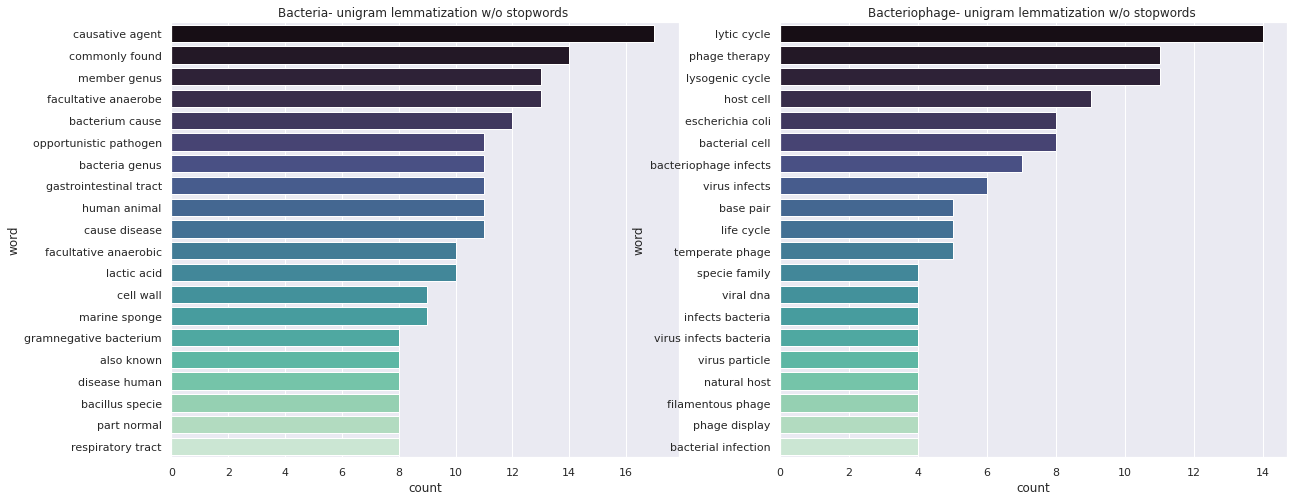

In [32]:
'''
Plotting max of 2 and 3 gram of bacteria vs bacteriophage
'''
## Calculating max 2 and 3 gram 
biotripplegram_bacteria = get_top_n_words(all_desc_bacteria, 20, 2,3)
biotripplegram_phage = get_top_n_words(all_desc_phage, 20, 2,3)
biotripplegram_bacteria = pd.DataFrame(biotripplegram_bacteria, columns = ['word' , 'count'])
biotripplegram_phage = pd.DataFrame(biotripplegram_phage, columns = ['word' , 'count'])

## Plot
fix, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
sns.barplot(x="count", y="word",orient="h",ax = ax1, palette="mako", data=biotripplegram_bacteria)
ax1.set_title("Bacteria- unigram lemmatization w/o stopwords ")
sns.barplot(x="count", y="word",orient="h", ax =ax2, palette="mako", data=biotripplegram_phage)
ax2.set_title("Bacteriophage- unigram lemmatization w/o stopwords ")
plt.tight_layout
plt.show()

Key insights:  


Named-Entity Recognition (NER)

In [33]:
# For now, we will keep all NERs
def generate_named_entities(comment):
    '''Returns the text snippet and its corresponding entity label in a list'''
    return [(ent.text.strip(), ent.label_) for ent in nlp(comment).ents ]

In [35]:
# Extract named entities for Description (on raw data)
df['named_entities'] = df['Description'].apply(generate_named_entities)
#df.reset_index(drop=True, inplace=True)

In [37]:
# Add simple token count to calculate the number of entities in a description
df['num_entities'] = df['named_entities'].apply(lambda x: len(x))


In [39]:
from spacy import displacy

In [44]:
# Let's inspect the NERs in the first three SA descriptions
for i in range(0,3):
    if df['named_entities'][i]:
        displacy.render(nlp(df['Description'][i]), style='ent', jupyter=True)

ValueError: ignored

In [38]:
df.head(2)

,Name,Description,Type,lang,Description_clean,word_count,char_count,sentence_count,avg_word_length,avg_sentence_length,Polarity,parsed,named_entities,num_entities
0,Acinetobacter baumannii,"Acinetobacter baumannii is a typically short, almost round, rod-shaped (coccobacillus) Gram-nega...",Bacteria,en,acinetobacter baumannii typically short almost round rodshaped coccobacillus gramnegative bacter...,354,2118,27,5.983051,13.111111,-0.019570,"(acinetobacter, baumannii, typically, short, almost, round, rodshaped, coccobacillus, gramnegati...","[(Paul Baumann, PERSON), (A. baumannii, PERSON), (Moraxellaceae, PERSON), (Moraxellaceae, PERSON...",16
1,Actinomyces israelii,"Actinomyces israelii is a species of Gram-positive, rod-shaped bacteria within the genus Actinom...",Bacteria,en,actinomyces israelii specie grampositive rodshaped bacteria within genus actinomyces known live ...,72,383,6,5.319444,12.000000,0.221591,"(actinomyces, israelii, specie, grampositive, rodshaped, bacteria, within, genus, actinomyces, k...","[(Gram, CARDINAL), (Actinomyces, PERSON), (German, NORP), (James Adolf, PERSON), (Israel, GPE), ...",8


In [ ]:

## tag text and exctract tags into a list
df["tags"] = df["Description"].apply(lambda x: [(tag.text, tag.label_) 
                                for tag in nlp(x).ents] )## utils function to count the element of a list

def utils_lst_count(lst):
    dic_counter = collections.Counter()
    for x in lst:
        dic_counter[x] += 1
    dic_counter = collections.OrderedDict( 
                     sorted(dic_counter.items(), 
                     key=lambda x: x[1], reverse=True))
    lst_count = [ {key:value} for key,value in dic_counter.items() ]
    return lst_count

## count tags
df["tags"] = df["tags"].apply(lambda x: utils_lst_count(x))

## utils function create new column for each tag category
def utils_ner_features(lst_dics_tuples, tag):
    if len(lst_dics_tuples) > 0:
        tag_type = []
        for dic_tuples in lst_dics_tuples:
            for tuple in dic_tuples:
                type, n = tuple[1], dic_tuples[tuple]
                tag_type = tag_type + [type]*n
                dic_counter = collections.Counter()
                for x in tag_type:
                    dic_counter[x] += 1
        return dic_counter[tag]
    else:
        return 0

## extract features
tags_set = []
for lst in df["tags"].tolist():
     for dic in lst:
          for k in dic.keys():
              tags_set.append(k[1])
tags_set = list(set(tags_set))
for feature in tags_set:
     df["tags_"+feature] = df["tags"].apply(lambda x: 
                             utils_ner_features(x, feature))
## print result
df.head()

In [ ]:
y = "Bacteria"
 
tags_list = df[df["Type"]==y]["tags"].sum()
map_lst = list(map(lambda x: list(x.keys())[0], tags_list))
dtf_tags = pd.DataFrame(map_lst, columns=['tag','type'])
dtf_tags["count"] = 1
dtf_tags = dtf_tags.groupby(['type',  
                'tag']).count().reset_index().sort_values("count", 
                 ascending=False)
fig, ax = plt.subplots()
fig.suptitle("Top frequent tags", fontsize=12)
sns.barplot(x="count", y="tag", hue="type", 
            data=dtf_tags.iloc[:,:], dodge=False, ax=ax)
ax.grid(axis="x")
plt.show()

In [ ]:
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

In [ ]:
## tag text and exctract tags into a list
df["pos_tags"] = df["Description"].apply(lambda x: 
                                nltk.pos_tag(nltk.tokenize.word_tokenize(x)) )## utils function to count the element of a list


In [ ]:
tmp = [("acinetobacter", "NN"), ("baumannii", "NN"), ("typically", "RB"), ("short", "JJ"),("acinetobacter", "NN")]
dic_counter = collections.Counter()
for x in tmp:
        dic_counter[x] += 1
dic_counter = collections.OrderedDict( 
                     sorted(dic_counter.items(), 
                     key=lambda x: x[1], reverse=True))
lst_count = [ {key:value} for key,value in dic_counter.items() ]


In [ ]:
dic_counter

In [ ]:
dic_counter

In [ ]:
lst_count

In [ ]:
## Count number of occurnace in a list and assign it in a list of dictionaries
def utils_lst_count(lst):
    dic_counter = collections.Counter() 
    for x in lst:
        dic_counter[x] += 1
    dic_counter = collections.OrderedDict( 
                     sorted(dic_counter.items(), 
                     key=lambda x: x[1], reverse=True))
    lst_count = [ {key:value} for key,value in dic_counter.items() ]
    return lst_count

## count position tag for each description
df["pos_tags"] = df["pos_tags"].apply(lambda x: utils_lst_count(x))

## utils function create new column for each tag category
def utils_ner_features(lst_dics_tuples, tag):
    if len(lst_dics_tuples) > 0:
        tag_type = []
        for dic_tuples in lst_dics_tuples:
            for tuple in dic_tuples:
                type, n = tuple[1], dic_tuples[tuple]
                tag_type = tag_type + [type]*n
                dic_counter = collections.Counter()
                for x in tag_type:
                    dic_counter[x] += 1
        return dic_counter[tag]
    else:
        return 0

## extract features
tags_set = []
for lst in df["pos_tags"].tolist():
     for dic in lst:
          for k in dic.keys():
              tags_set.append(k[1])
tags_set = list(set(tags_set))
for feature in tags_set:
     df["pos_tags_"+feature] = df["pos_tags"].apply(lambda x: 
                             utils_ner_features(x, feature))
## print result
df.head(2)

In [ ]:
y = "Bacteria"
 
tags_list = df[df["Type"]==y]["pos_tags"].sum()
map_lst = list(map(lambda x: list(x.keys())[0], tags_list))
df_tags = pd.DataFrame(map_lst, columns=['tag','type'])
df_tags["count"] = 1
df_tags = df_tags.groupby(['type',  
                'tag']).count().reset_index().sort_values("count", 
                 ascending=False)
fig, ax = plt.subplots()
fig.suptitle("Top frequent tags", fontsize=12)
sns.barplot(x="count", y="tag", hue="type", 
            data=df_tags.iloc[:,:], dodge=False, ax=ax)
ax.grid(axis="x")
plt.show()

In [ ]:
df.head(2)

In [ ]:
## call model
ner = spacy.load("en_core_web_sm")
nltk.pos_tag()
## tag text and exctract tags into a list
df["pos_tags"] = df["Description_clean"].apply(lambda x: [(tag.text, tag.label_) 
                                for tag in nltk.pos_tag(x)] )## utils function to count the element of a list

def utils_lst_count(lst):
    dic_counter = collections.Counter()
    for x in lst:
        dic_counter[x] += 1
    dic_counter = collections.OrderedDict( 
                     sorted(dic_counter.items(), 
                     key=lambda x: x[1], reverse=True))
    lst_count = [ {key:value} for key,value in dic_counter.items() ]
    return lst_count

## count tags
df["tags"] = df["tags"].apply(lambda x: utils_lst_count(x))

## utils function create new column for each tag category
def utils_ner_features(lst_dics_tuples, tag):
    if len(lst_dics_tuples) > 0:
        tag_type = []
        for dic_tuples in lst_dics_tuples:
            for tuple in dic_tuples:
                type, n = tuple[1], dic_tuples[tuple]
                tag_type = tag_type + [type]*n
                dic_counter = collections.Counter()
                for x in tag_type:
                    dic_counter[x] += 1
        return dic_counter[tag]
    else:
        return 0

## extract features
tags_set = []
for lst in df["tags"].tolist():
     for dic in lst:
          for k in dic.keys():
              tags_set.append(k[1])
tags_set = list(set(tags_set))
for feature in tags_set:
     df["tags_"+feature] = df["tags"].apply(lambda x: 
                             utils_ner_features(x, feature))
## print result
df.head()